In [44]:
import matplotlib.pyplot as plt, numpy as np, torch as tch

# Perplexity

In the FlashAttention paper last week, the authors claimed models produced by their algorithm were obtained with less computation but of equal quality, and cited equivalent "perplexity" (ppl) as proof. 

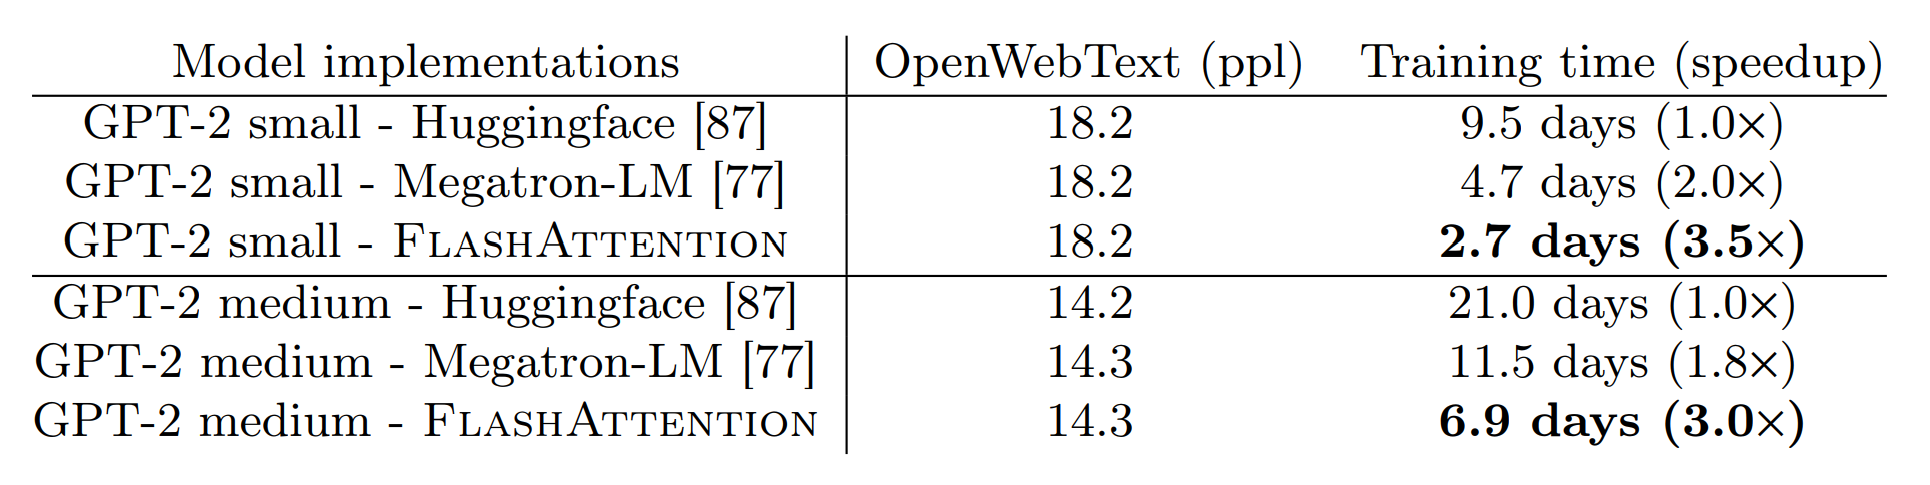

Later in the same paper, they increase the context window and obtain better (lower) perplexity.  Let's try to understand the intuition and mathematics behind the definition of perplexity.

Many of the concepts and terms involved have competing names, and expressions have often have forms that are algebraically equivalent or differ by a scaling constant, but we'll try and untangle them.

### Information/surprise

I'll take a first principles or characterization type of approach.  Let $A$ be a random event (such as obtaining heads from a possibly unfair coin, or encountering a particular word in a sentence), and let $p$ be the probability of $A$.  We would like to define a function that measures how surprised we would be to observe the event.  Alternatively, we could think of how much **information** we could gain by observing the event, so we'll call the function $I$.  There are three properties that we'd want the function to satisfy.

1.  It should be monotonically decreasing, so if $p$ increases $I(p)$ decreases.  The more likely an event is, the less surprised we are to see it, and the less information we learn from it.  This suggests an inverse relationship, perhaps with $p$ in the denominator.

2.  Events that are certain should give us no information or surprise at all, so $I(1) = 0$ is desired.

3. The information from independent events should be additive.  For example, observing the event three times should give three times as much information.  If $A$ and $B$ are independent, $P(A \cap B) = P(A)P(B)$, so how do we turn this multiplication into a sum?  Well, recall this property of logarithms: $\log (xy) = \log(x) + \log(y)$

Properties 1. and 3. suggest the following, which happily satisfies property 2. as well:

$$I(p) = \log\left(\frac{1}{p} \right) = \log\left(p^{-1}\right) = -\log(p)$$

If you noticed I didn't specify a base for the logarithm, that's because it doesn't really matter.  Because of the change of base formula

$$\log_ax = \frac{1}{\log_ba}\log_bx$$

the value of $I(p)$ would only change by a constant multiple.  Bases 2, $e$, and 10 are all common.  I'll use 2 because it has a connection to optimal compression (though we won't explore it).

Text(0, 0.5, 'Information from the event')

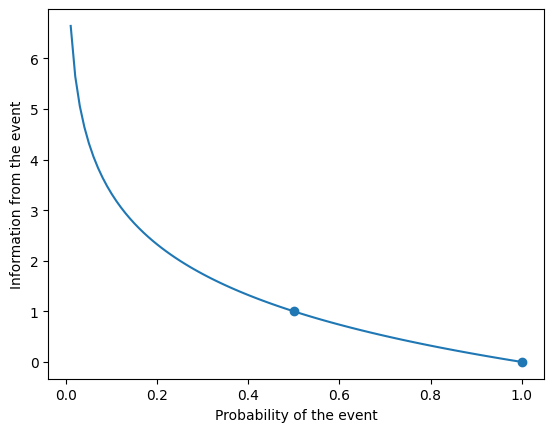

In [2]:
p = np.linspace(0, 1, 101)[1:]
I = -np.log2(p)
plt.plot(p, I)
plt.scatter([.5, 1], [1, 0])
plt.xlabel('Probability of the event')
plt.ylabel('Information from the event')


### Entropy

Let's step up from a single event $A$ to a discrete distribution $p$ over $K$ possible outcomes (such as rolling a $K$ sided die, an NLP model over $K$ words, etc.).  The outcomes themselves aren't important for developing the concepts.   I'll use the shorthands $p_k$ for the probability of the *k*th outcome and $I(k)$ for the information or surprise when seeing the *k*th outcome, $k = 1, 2, \ldots, K$.  For example,

| p_k    | I(k) |
|--------|------| 
| .25    | 2    |
| .75    | .415 |

A natural next step is to average the information over the outcomes.  This is the **entropy** of the distribution: the expected value (weighted average) of the information.  It it is usually denoted $H(p)$, but if $p$ represents the probabilities for a discrete random variable $X$, you may see $H(X)$.  Let $m$ be the number of values the random variable can take.

$$H(p) = -\sum_{k=1}^K p_k \log p_k = \sum_{k=1}^K \log \left(p_k^{-p_k}\right) = \log \left(\prod_{k=1}^K p_k^{-p_k}\right)$$

For the random variable above, $H(p) = .25*2 + .75*.415 = .81$

**Intuition check:**  Will a fair coin have a higher or lower entropy?




In [32]:
p = [.5, .5]
I = -np.log2(p)
print(f'The entropy is {sum(p * I)}')

The entropy is 1.0


**Answer:**  Higher! In general, distributions with evenly spread probabilities have higher entropy (they have more inherent uncertainty), and distributions with highly likely values have lower entropy.

In the cell below, you can rapidly calculate entropy for an arbitrary $m$-sided die.

In [35]:
m = 6
p = [1/m for _ in range(m)]
I = -np.log2(p)
print(f'The entropy is {sum(p * I)}')

The entropy is 2.584962500721156
2 raised to the entropy is 6.0


### Perplexity

This won't yet look like the expression for perplexity commonly used in NLP (we'll get there eventually), but look what happens when we exponentiate the entropy using the same base as the logarithm.  The **perplexity** is

$$
PP(p) = 2^{H(p)} = 2 \text{ } \^{} \left\{ -\sum_{k=1}^K p_k \log p_k \right\} = \prod_{k=1}^K p_k^{-p_k}
$$ 

Notice the perplexity values are very nice for $m$-sided dice distributions.

In [6]:
K = 5
p = [1/K for _ in range(K)]
I = -np.log2(p)
print(f'The perplexity is {round(2 ** sum(p * I), 5)}')

The perplexity is 5.0


This gives a nice way to gauge the uncertainty in a probability distribution.  Round the perplexity to the nearest whole number, and the uncertainty is akin to rolling a fair die with that many sides.

In [26]:
# 6 outcomes, but one is somewhat likely, 
# so uncertainty is comparable to a 3 sided die.
p = [.7, .06, .06, .06, .06, .06]
I = -np.log2(p)
print(f'The perplexity is {round(2 ** sum(p * I), 5)}')

The perplexity is 2.98529


### Cross-entropy with known distributions

Until now, we've assumed that we know the probabilities in the logarithm (the "surprise" part of the formula) and the weighting probabilities (in the averaging part of the formula) are the same.  But what if the data actually follows a different distribution $q$?  The **cross-entropy** $H(q, p)$ is the average surprise of seeing outcomes when we think that $p$ is the distribution, but actually $q$ is the true distribution (I'm assuming $p$ and $q$ have the same support, that is, the set of outcomes that are possible).

$$
H(q, p) = - \sum_{k=1}^K q_k \log p_k
$$

There are a few properties of this definition that are worth noting.

Property 1: If $q = p$ (that is, if they represent the same probability distribution) then the cross-entropy is equal to the entropy.
$$
H(p, p) = - \sum_{k=1}^K p_k \log p_k = H(p)
$$

Property 2: The cross entropy is not symmetric.
$$
H(q, p) \neq H(p, q) \text{ in general.}
$$


In [45]:
# p represents a fair coin
p = [.5, .5]
# q represents a coin heavily weighted towards heads
q = [.9, .1]

# This represents the surprise in seeing mostly heads when we think the coin is fair
print(f'The cross-entropy H(q, p) is {round(-sum(q * np.log2(p)), 5)}')

# This represents the surprise in seeing balanced outcomes when we think the coin is weighted
print(f'The cross-entropy H(p, q) is {round(-sum(p * np.log2(q)), 5)}')

The cross-entropy H(q, p) is 1.0
The cross-entropy H(p, q) is 1.73697


Property 3: The cross-entropy $H(q, p)$ is greater than or equal to the entropy of the true distribution $q$, with equality only when $q=p$.
$$
H(q, p) \geq H(q)
$$

If you're curious about the mathematical details, see Gibbs' inequality: https://en.wikipedia.org/wiki/Gibbs%27_inequality

In [46]:
p = [.5, .5]
q = [.9, .1]

print(f'The cross-entropy H(q, p) is {sum(q * -np.log2(p))}')
print(f'The entropy H(q) is {sum(q * -np.log2(q))}')

The cross-entropy H(q, p) is 1.0
The entropy H(q) is 0.4689955935892812


We can develop the last property into a loss function for classification.  If the model is adjusted (implicitly adjusting the assumed distribution $p$) until the cross-entropy is as low as possible, then $p \approx q$.  But of course, the true distribution $q$ isn't known exactly... it must be estimated from a sample.

### Cross-entropy with samples

As we move towards application, let's update the notation for the assumed distribution $p$ to $p_\theta$, to make explicit that we aren't working directly with the probabilities, but they are implied by model parameter(s) $\theta$, such as the weights and biases of a neural network.  Let's also drop the assumption that the true distribution $q$ is known.  Assume instead that we can draw samples from it.

Let $x_1, x_2, \ldots x_N$ be observations from the true but unknown distribution $q$ (remember these values $x_i$ are usually not numeric; in this context they are typically categorical outcomes such as words).  Form the empirical distribution $\hat{q}$ by calculating frequencies from the sample.

$$\hat{q}_k = \frac{n_k}{N} \text{ for } k = 1,\ldots,K \text{ where } n_k \text{ is the number of times outcome } k \text{ is observed.}$$

Imagine reordering the sample so that all occurences of each outcome are grouped.  This step is just to make an algebraic manipulation easier to understand, and isn't necessary to actually train a model.

$$ \underbrace{x_1, x_2, \ldots, x_{n_1}}_\textrm{$n_1$ of 1st outcome}, \underbrace{x_{n_1+1}, \ldots x_{n_1 + n_2}}_\textrm{$n_2$ of 2nd outcome}, \ldots, \underbrace{x_{N - n_K + 1}, \ldots, x_N}_\textrm{$n_K$ of last outcome}$$

In this context, consider the cross-entropy again.

$$
H(\hat{q}, p_\theta) 
= -\sum_{k=1}^K \hat{q}_k \log p_{\theta, k} 
= -\sum_{k=1}^K \frac{n_k}{N} \log p_{\theta, k}
= -\frac{1}{N} \sum_{k=1}^K n_k \log p_{\theta, k}
= -\frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k} \log p_\theta(x_i)
= -\frac{1}{N} \sum_{i=1}^{N} \log p_\theta(x_i)
$$ 

This has actually simplified things quite a bit.  This empirical form of cross-entropy is simply averaging the log probabilities of the model's classification probabilities.  If the model can classify correctly and confidently, the $-\log p_\theta(x_i)$ terms will be small, and the cross-entropy will be low.  If the model has more uncertainty in classifying, this value is high.

Check out the documentation for Pytorch's implementation of CrossEntropyLoss.  It has some extra options not discussed in these notes (weighting and a limit on indices), so ignore those.  When the $p_\theta(x_i)$ term is replaced with the softmax that produces it, the formulas are identical.  The web page is easier to read:
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
# Ctrl-click and check out the documentation
tch.nn.CrossEntropyLoss

### Perplexity revisited